This notebook is an example of what it looks like to upload my personal saved SVMs (either original or lowRES) and use them on presaved detector plane images (dpis). 
Adjust filepaths as needed. 
original dpis are 286x173 pixels
lowRES dpis are 16x16x2 including the 3rd energy bin dimension

In [20]:
resolution = "lowRES"   # which SVM you would like to use: 'original' or 'lowRES'

Test length (all DPI files): 530

Test 1:
Predicted: GRB
REAL: GRB
Confidence in predicted class: 0.9258
Confidence in class GLITCH: 0.0742
Confidence in class GRB: 0.9258
__________________________________________

Test 2:
Predicted: GLITCH
REAL: GLITCH
Confidence in predicted class: 0.9983
Confidence in class GLITCH: 0.9983
Confidence in class GRB: 0.0017
__________________________________________




lowRES model accuracy (for all): 0.96




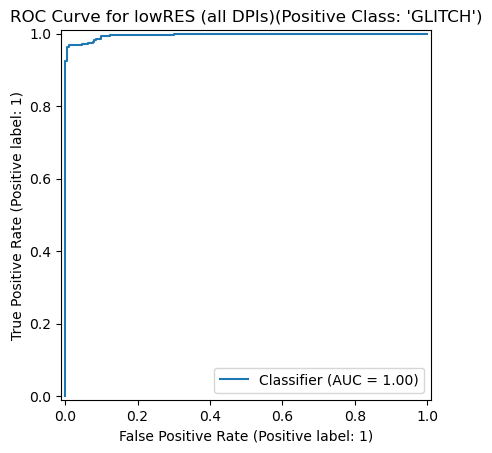

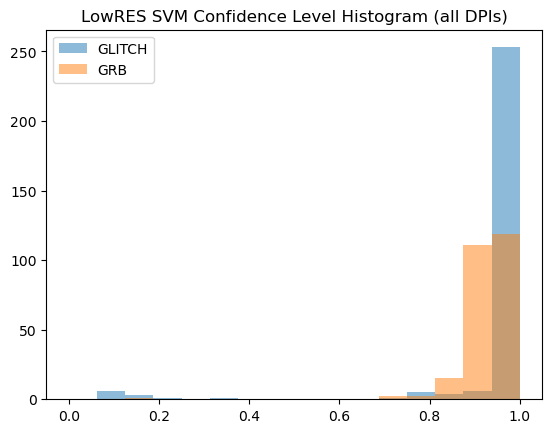

In [24]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

if resolution == "original":
    
    GRBdir = "GRBdpi"    # path to your original resolution GRB DPIs here
    GLITCHdir = os.path.expanduser("~/scratch/GLITCHdpi")  # path to your original resolution glitch DPIs here
    
    model_path = "svm_original_model.pkl"
    roc_title = "ROC Curve for original (all DPIs)(Positive Class: 'GLITCH')"
    hist_title = "Original SVM Confidence Level Histogram (all DPIs)"

else:
    
    GRBdir = "GRBdpi_lowRES"    # path to your lower resolution/binned GRB DPIs here
    GLITCHdir = os.path.expanduser("~/scratch/GLITCHdpi_lowRES")   # path to your lower res/binned glitch DPIs here
    
    model_path = "svm_lowRES_model.pkl"
    roc_title = "ROC Curve for lowRES (all DPIs)(Positive Class: 'GLITCH')"
    hist_title = "LowRES SVM Confidence Level Histogram (all DPIs)"


def load_dpis(dpi_dir, label):
    files = [f for f in os.listdir(dpi_dir) if f.endswith('.npy')]
    data = []
    targets = []
    
    for file in files:
        dpi = np.load(os.path.join(dpi_dir, file), allow_pickle=True)
        data.append(np.ravel(dpi)) #flattening dpi
        targets.append(label)
        
    return data, targets



grb_data, grb_targets = load_dpis(GRBdir, "GRB")
glitch_data, glitch_targets = load_dpis(GLITCHdir, "GLITCH")

data = np.array(grb_data + glitch_data)
targets = np.array(grb_targets + glitch_targets)


combined = list(zip(data, targets))
np.random.shuffle(combined)
data, targets = zip(*combined)
data = np.array(data)
targets = np.array(targets)


# --- Load pretrained SVM model --- #
with open(model_path, "rb") as f:
    clf = pickle.load(f)
    

predicted = clf.predict(data)
probabilities = clf.predict_proba(data)

class_indices = {cls: idx for idx, cls in enumerate(clf.classes_)}

print(f"Test length (all DPI files): {len(data)}")
   

for i in range(min(2, len(data))):        # min(10, len(data))):  all: (len(data)):
    print(f"\nTest {i+1}:")
    print(f"Predicted: {predicted[i]}")
    print(f"REAL: {targets[i]}")
    predicted_class_index = class_indices[predicted[i]]
    print(f"Confidence in predicted class: {probabilities[i][predicted_class_index]:.4f}")
    for cls in clf.classes_:
        idx = class_indices[cls]
        print(f"Confidence in class {cls}: {probabilities[i][idx]:.4f}")
    print("_" * 42)
print()
    
   
    # VISUALIZING THE SVM

# accuracy
accuracy = np.mean(predicted == targets)
print(f"\n\n\n{resolution} model accuracy (for all): {accuracy:.2f}")

print()
print()

# roc_curve
positiveclass_is1 = class_indices['GLITCH']   # mkae GLITCH positive class (1)
y_score = probabilities[:, positiveclass_is1]   #glitch proba
y_test_is1 = [1 if label == 'GLITCH' else 0 for label in targets]   #assign binary  1 is positive class
RocCurveDisplay.from_predictions(y_test_is1, y_score)
plt.title(roc_title)
plt.show()

print()
print()

# histograms
glitch_index = class_indices["GLITCH"]
grb_index = class_indices["GRB"]

bin_edges = np.linspace(0, 1, 17)
        
is_glitch = np.array(targets) == "GLITCH"
is_grb = np.array(targets) == "GRB"

plt.hist(probabilities[:, glitch_index][is_glitch], bins=bin_edges, alpha=0.5, label="GLITCH")
plt.hist(probabilities[:, grb_index][is_grb], bins=bin_edges, alpha=0.5, label="GRB")

plt.title(hist_title)
plt.legend()
plt.show()